In [9]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

from visualization.utils import gradient_line

In [10]:
# where to grab the postprocessing metrics from

NUM_USER_GROUPS = 3

POSTPROCESSING_EXPERIMENTS = {
    ('BPR', 'ML-1M'): 'metrics/ml-1m-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0001.json',
    ('DMF', 'ML-1M'): 'metrics/ml-1m-dmf/c0.0__frozen_itememb__selection_relevance__k100__lr0.0005.json',
    ('BPR', 'AMBAR'): 'metrics/ambar-bpr/c0.0__frozen_itememb__selection_relevance__k100__lr0.0001.json',
    ('DMF', 'AMBAR'): 'metrics/ambar-dmf/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json',
}

EXPERIMENTS_TO_SHOW = {
    ('BPR', 'ML-1M'): {
        'lr': 'lr0.0001',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k100',
        'alphas': [
            # 0.0,
            # 0.1,
            0.25,
            # 0.5,
            # 0.75,
            # 1.0
        ]
    },
    ('BPR', 'AMBAR'): {
        'lr': 'lr0.0001',
        'frozen_itememb': 'unfrozen_itememb',
        'k_candidates': 'k200',
        'alphas': [
            # 0.0,
            # 0.1,
            # 0.25,
            # 0.5,
            # 0.75,
            1.0
        ]
    },
}

data = {}

for subplot in EXPERIMENTS_TO_SHOW.keys():
    model_class, dataset = subplot
    data[subplot] = {
        'base_model': model_class,
        'dataset': dataset,
        'finetuned': {}
    }

    metrics_folder = f'{dataset.lower()}-{model_class.lower()}'

    lr = EXPERIMENTS_TO_SHOW[subplot]['lr']
    frozen_itememb = EXPERIMENTS_TO_SHOW[subplot]['frozen_itememb']
    k_candidates = EXPERIMENTS_TO_SHOW[subplot]['k_candidates']
    alphas = EXPERIMENTS_TO_SHOW[subplot]['alphas']

    try:
        with open(POSTPROCESSING_EXPERIMENTS[(model_class, dataset)]) as f:
            experiment_data = json.load(f)
            data[subplot]['base_model_metrics'] = {
                'ndcg': experiment_data['base_recommendations']['ndcg'],
                'jsd': experiment_data['base_recommendations']['jsd']
            }
            for i in range(1, NUM_USER_GROUPS + 1):
                data[subplot]['base_model_metrics'][f'ndcg_usergroup_{i}'] = experiment_data['base_recommendations'][f'ndcg_usergroup_{i}']
                data[subplot]['base_model_metrics'][f'jsd_usergroup_{i}'] = experiment_data['base_recommendations'][f'jsd_usergroup_{i}']

            postprocessed_ndcgs = [[] for _ in range(NUM_USER_GROUPS + 1)]
            postprocessed_jsds = [[] for _ in range(NUM_USER_GROUPS + 1)]
            for l in experiment_data['postprocessed'].keys():
                postprocessed_ndcgs[0].append(experiment_data['postprocessed'][l]['ndcg'])
                postprocessed_jsds[0].append(experiment_data['postprocessed'][l]['jsd'])
                for i in range(1, NUM_USER_GROUPS + 1):
                    postprocessed_ndcgs[i].append(experiment_data['postprocessed'][l][f'ndcg_usergroup_{i}'])
                    postprocessed_jsds[i].append(experiment_data['postprocessed'][l][f'jsd_usergroup_{i}'])

            data[subplot]['postprocessed'] = {
                'ndcg': postprocessed_ndcgs,
                'jsd': postprocessed_jsds
            }
            for i in range(1, NUM_USER_GROUPS + 1):
                data[subplot]['postprocessed'][f'ndcg_usergroup_{i}'] = postprocessed_ndcgs[i]
                data[subplot]['postprocessed'][f'jsd_usergroup_{i}'] = postprocessed_jsds[i]
    except FileNotFoundError:
        print('Experiment with Postprocessing data not found, skipping!')

    for alpha in alphas:
        experiment_name = f'c{alpha}__{frozen_itememb}__selection_relevance__{k_candidates}__{lr}.json'
        file = os.path.join('metrics', metrics_folder, experiment_name)

        if not os.path.exists(file):
            print(f"Missing experiment metrics file {file}! Skipping...")
            continue
        with open(file) as f:
            d = json.load(f)
            data[subplot]['finetuned'][alpha] = {
                'ndcg': [d['finetuned'][l]['ndcg'] for l in d['finetuned'].keys()],
                'jsd': [d['finetuned'][l]['jsd'] for l in d['finetuned'].keys()]
            }
            for i in range(1, NUM_USER_GROUPS + 1):
                data[subplot]['finetuned'][alpha][f'ndcg_usergroup_{i}'] = [d['finetuned'][l][f'ndcg_usergroup_{i}'] for l in d['finetuned'].keys()]
                data[subplot]['finetuned'][alpha][f'jsd_usergroup_{i}'] = [d['finetuned'][l][f'jsd_usergroup_{i}'] for l in d['finetuned'].keys()]

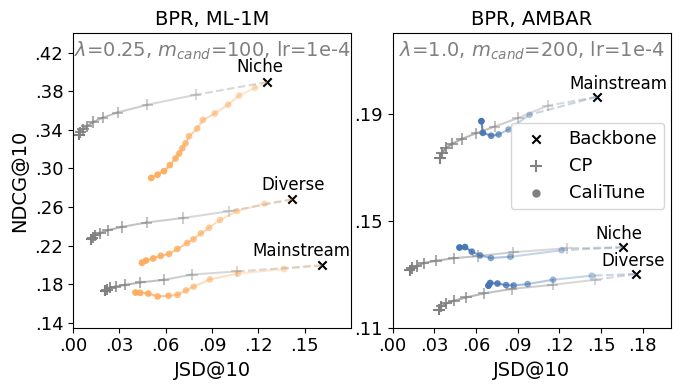

In [11]:
SUBPLOTS = [
    ('BPR', 'ML-1M'),
    ('BPR', 'AMBAR'),
    # ('DMF', 'ML-1M'),
    # ('DMF', 'AMBAR'),
]

JSD_RANGE = {
    ('BPR', 'ML-1M'): [0, 0.18],
    # ('DMF', 'ML-1M'): [0, 0.2],
    ('BPR', 'AMBAR'): [0, 0.2],
    # ('DMF', 'AMBAR'): [0, 0.2],
}
NDCG_RANGE = {
    ('BPR', 'ML-1M'): [0.135, 0.44],
    # ('DMF', 'ML-1M'): [0, 1.0],
    ('BPR', 'AMBAR'): [0.11, 0.22],
    # ('DMF', 'AMBAR'): [0, 1.0],
}

LR_LABELS = {
    'lr0.0001': '1e-4',
    'lr0.0005': '5e-4',
    'lr1e-05': '1e-5',
}

ALPHA_COLORS = {
    0.0: '#d73027',
    0.1: '#f46d43',
    0.25: '#fdae61',
    0.5: '#fee090',
    0.75: '#74add1',
    1.0: '#4575b4'
}

USER_GROUP_LABELS = [
    '(All)',
    'Mainstream',
    'Diverse',
    'Niche'
]

USER_GROUP_MARKERS = [
    'o',
    '+',
    'x',
    's'
]

SUBPLOT_SIZE = 4
fig, axes = plt.subplots(1, len(SUBPLOTS), figsize=(SUBPLOT_SIZE * len(SUBPLOTS) - 1, SUBPLOT_SIZE))

for idx, (model, dataset) in enumerate(SUBPLOTS):
    subplot_data = data[(model, dataset)]#

    ax = axes[idx]

    ax.set_title(f'{model}, {dataset}', fontsize=14)

    lr = EXPERIMENTS_TO_SHOW[(model, dataset)]['lr']
    k_candidates = EXPERIMENTS_TO_SHOW[(model, dataset)]['k_candidates']
    frozen = EXPERIMENTS_TO_SHOW[(model, dataset)]['frozen_itememb']
    if frozen == 'frozen_itememb':
        frozen_label = ', Frozen Item Emb.'
    else:
        frozen_label = ''  # Intentionally left blank

    fixed_params = f'$m_{{cand}}$={k_candidates[1:]}, lr={LR_LABELS[lr]}{frozen_label}'

    if len(subplot_data['finetuned'].keys()) == 1:
        # Prepend lambda to the information
        alpha = list(subplot_data['finetuned'].keys())[0]
        fixed_params = f'$\lambda$={alpha}, ' + fixed_params

    ax.text(0.5, 0.94, fixed_params, ha='center', va='center', transform=ax.transAxes, fontsize=14, color='gray')

    ax.set_xlabel('JSD@10', fontsize=14)
    if idx == 0:
        ax.set_ylabel('NDCG@10', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=13)

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x).lstrip('0')))

    ax.set_xlim(*JSD_RANGE[(model, dataset)])
    ax.set_ylim(*NDCG_RANGE[(model, dataset)])

    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.03), 2))

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.04), 2))

    for group in range(1, NUM_USER_GROUPS + 1):
        starting_point = [
            subplot_data['base_model_metrics'][f'jsd_usergroup_{group}'],
            subplot_data['base_model_metrics'][f'ndcg_usergroup_{group}']
        ]
        # Plot Backbone Model
        ax.scatter(
            starting_point[0],
            starting_point[1],
            marker='x', color='black',
            label='Backbone' if group == 1 else '',
        )

        manual_label_offsets = {
            (0, 1): (-0.045, 0.01),
            (0, 2): (-0.02, 0.01),
            (0, 3): (-0.02, 0.01),
            (1, 1): (-0.02, 0.003),
            (1, 2): (-0.025, 0.003),
            (1, 3): (-0.02, 0.003),
        }
        offset = manual_label_offsets[(idx, group)]

        ax.annotate(
            USER_GROUP_LABELS[group],
            xy=starting_point,
            xytext=[
                starting_point[0] + offset[0],
                starting_point[1] + offset[1]
            ],
            fontsize=12,
            # arrowprops={
            #     'arrowstyle': '->',
            # }
        )
        # Plot postprocessing line
        if 'postprocessed' in subplot_data.keys():
            gradient_line(
                subplot_data['postprocessed'][f'jsd_usergroup_{group}'],
                subplot_data['postprocessed'][f'ndcg_usergroup_{group}'],
                ax,
                c='gray', marker='+',
                lbl='CP' if group == 1 else '',
                starting_point=starting_point,
                scatter_size=65,
                # final_model_label=USER_GROUP_LABELS[group]
            )

        # Plot finetuned lines
        for alpha in subplot_data['finetuned'].keys():
            alpha_data = subplot_data['finetuned'][alpha]

            # Get color for alpha
            color = ALPHA_COLORS[alpha]
            # Plot gradient line
            gradient_line(
                alpha_data[f'jsd_usergroup_{group}'],
                alpha_data[f'ndcg_usergroup_{group}'],
                ax,
                c=color, marker='o',
                # lbl=f'CaliTune' if group == 1 else '',
                starting_point=starting_point,
                threshold=0.005,
                # final_model_label=USER_GROUP_LABELS[group]
            )
            if group == 1 and idx == len(SUBPLOTS) - 1:
                # Fake scatter for legend
                ax.scatter([], [], c='gray', alpha=1, label=f'CaliTune', marker='o', s=25)
                ax.legend(fontsize=13, loc='center right', bbox_to_anchor=(1.01, 0.55))

plt.tight_layout()
# plt.legend()
plt.subplots_adjust(wspace=0.15)  # smaller wspace leads to less horizontal padding
plt.savefig('visualization/pdf/calitune_user_groups.pdf')
plt.show()